## Need to get accurate detection working.

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import pandas as pd

Use the code from `diffimTests.py`.

In [3]:
import diffimTests as dit
reload(dit)

# Let's try w same parameters as ZOGY paper.
sky = 300.

testObj = dit.DiffimTest(imSize=(512,512), sky=sky, offset=[0,0], psf_yvary_factor=0., varSourceChange=1500., 
                         theta1=0., theta2=-45., im2background=0., n_sources=50, sourceFluxRange=(500,30000), 
                         seed=66, psfSize=13)

print dit.computeClippedImageStats(testObj.im1.im)
print dit.computeClippedImageStats(testObj.im2.im)
print dit.computeClippedImageStats(testObj.im1.var)
print dit.computeClippedImageStats(testObj.im2.var)

Template PSF: [1.6, 1.6] 0.0
Science PSF: [1.8, 2.2] -45.0
0.824621125124
Offset: [0, 0]
PSF y spatial-variation: 0.0 0.0
Variable source: 37 245.899250131 279.361590046 1423.89964966 2923.89964966
(0.058941207521673616, 17.142582277831181, -74.0, 1741.5550996425638)
(0.16735074378053241, 17.213851327082029, -82.0, 1169.0572762553779)
(300.05894120752163, 17.142582277831185, 226.0, 2041.5550996425638)
(300.16735074378062, 17.213851327082025, 218.0, 1469.0572762553779)


In [4]:
res = testObj.doALInStack(doPreConv=False, doDecorr=True)
D_AL = res.decorrelatedDiffim.getMaskedImage().getImage().getArray()
print np.sum((D_AL == 0) | np.isnan(D_AL) | np.isinf(D_AL))
D_AL[0,:] = D_AL[:,0] = D_AL[-1,:] = D_AL[:,-1] = 0.
D_AL[np.isnan(D_AL) | np.isinf(D_AL)] = 0.
print dit.computeClippedImageStats(D_AL)
D_ZOGY = testObj.doZOGY()
print np.sum((D_ZOGY.im == 0) | np.isnan(D_ZOGY.im) | np.isinf(D_ZOGY.im))
#D_ZOGY.im[D_AL == 0.] = 0.
print dit.computeClippedImageStats(D_ZOGY.im)
S_ZOGY = testObj.S_corr_ZOGY
print np.sum((S_ZOGY.im == 0) | np.isnan(S_ZOGY.im) | np.isinf(S_ZOGY.im))
#S_ZOGY.im[D_AL == 0.] = 0.
print dit.computeClippedImageStats(S_ZOGY.im)

54208
(-0.0015253216, 0.85330808, -4.7341161, 7.554749)
0
(-0.00091946279216619279, 0.98658699240597725, -4.8672571236886055, 4.4549309460273108)
0
(0.010771440925175148, 0.97869443986664717, -4.527872818281959, 9.1269917837064956)


/home/dreiss/lsstsw/miniconda/lib/python2.7/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/home/dreiss/lsstsw/miniconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/dreiss/lsstsw/miniconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/dreiss/lsstsw/miniconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1147: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)


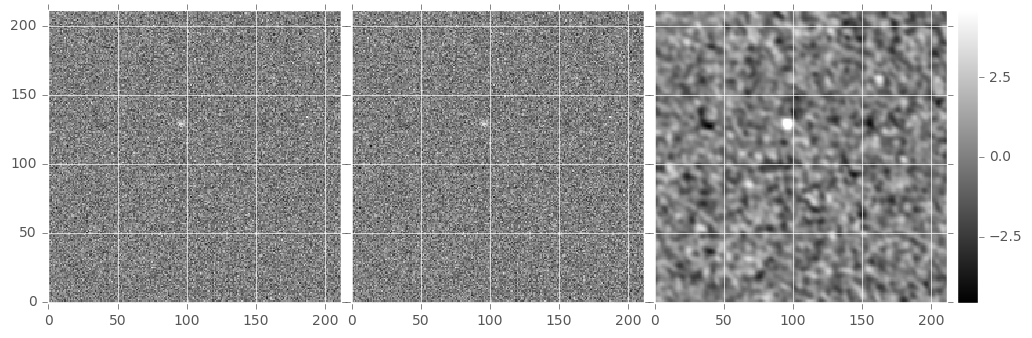

In [5]:
fig = plt.figure(1, (12, 12))
x1d, x2d, y1d, y2d = 150, 512-150, 150, 512-150   # limits for display
dit.plotImageGrid((D_AL[x1d:x2d,y1d:y2d], D_ZOGY.im[x1d:x2d,y1d:y2d], S_ZOGY.im[x1d:x2d,y1d:y2d]))

In [6]:
reload(dit)
import pandas as pd

changedCentroid = testObj.centroids[testObj.changedCentroidInd, :]
print changedCentroid

# update: need to set mask on edge values. They're zero so they're setting the stdev of the image too low.
src_AL = dit.doDetection(res.decorrelatedDiffim)
src_ZOGY = dit.doDetection(D_ZOGY.asAfwExposure())
src_SZOGY = dit.doDetection(S_ZOGY.asAfwExposure(), doSmooth=False)

df = pd.DataFrame({col: src_AL.columns[col] for col in src_AL.schema.getNames()})
print df.base_NaiveCentroid_x.values, df.base_NaiveCentroid_y.values, \
    df.base_PeakLikelihoodFlux_flux.values, df.base_PsfFlux_flag.values, \
    df.base_PsfFlux_flag_edge.values
df = pd.DataFrame({col: src_ZOGY.columns[col] for col in src_ZOGY.schema.getNames()})
print df.base_NaiveCentroid_x.values, df.base_NaiveCentroid_y.values, \
    df.base_PeakLikelihoodFlux_flux.values, df.base_PsfFlux_flag.values, \
    df.base_PsfFlux_flag_edge.values
df = pd.DataFrame({col: src_SZOGY.columns[col] for col in src_SZOGY.schema.getNames()})
print df.base_NaiveCentroid_x.values, df.base_NaiveCentroid_y.values, \
    df.base_PeakLikelihoodFlux_flux.values, df.base_PsfFlux_flag.values, \
    df.base_PsfFlux_flag_edge.values

[  245.89925013   279.36159005  1423.89964966]
[ 415.12979634  245.30795197] [  35.05332157  278.27599121] [ 382.08973785  190.63916636] [ True False] [False False]
[ 245.2977583] [ 278.27272629] [ 165.37804473] [False] [False]
[ 246.00500017] [ 279.00892644] [ 391.35131404] [False] [False]


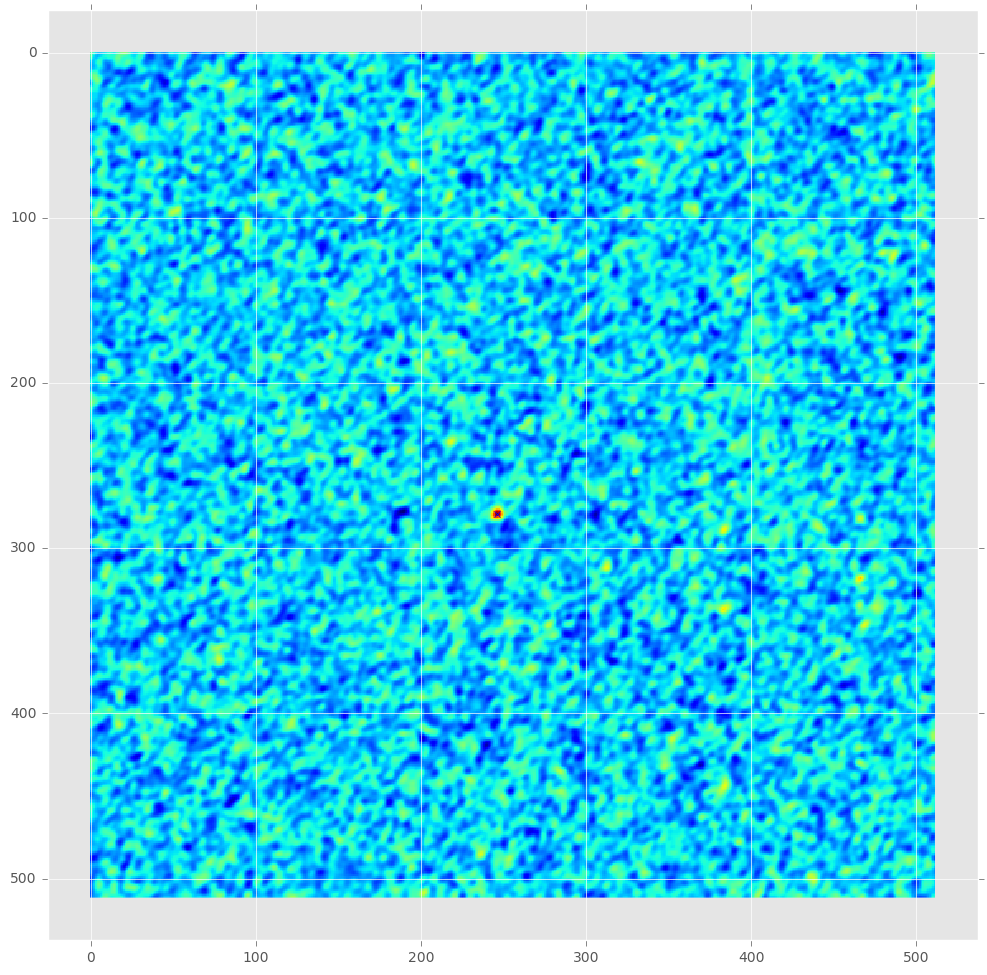

In [10]:
df = pd.DataFrame({col: src_SZOGY.columns[col] for col in src_SZOGY.schema.getNames()})
fig = plt.figure(1, (12, 12))
plt.imshow(S_ZOGY.im, interpolation='none')
plt.scatter(df.base_NaiveCentroid_x.values, df.base_NaiveCentroid_y.values, marker='x')